# IMDB Sentiment Analysis
### Practical Data Science Final Project 
By Boushra Bendou and Jullia Montejo

# Introduction and Motivation

In this current era, where an abundance of digital content and entertainment are produced daily, consumers heavily rely on online ratings when deciding whether content is worth their time. Because of this, IMDb stands out as it offers consumers, from movie enthusiasts, professionals in the film industry, and casual viewers, a platform to share their reviews on movies. The vast amount of user-generated movie reviews on IMDb then contributes to the creation of a collective narrative about movies that helps consumers make decisions about their viewing choices.

Our project's primary objective is to employ natural language processing techniques to build a predictive model which would conclude the underlying sentiments within user-generated IMDb reviews. Training our predictive model to detect patterns using supervised learning techniques on our labelled dataset enables it to precisely detect the sentiments behind user reviews on IMDb.

Not only might casual movie viewers be influenced by our project's model but the professional film industry may also be impacted by it. Filmmakers may utilize sentiment analysis to better understand the nuanced responses of their audience and to influence and improve their next films in order to better appeal to the target market.

## Table of Contents:
1. [Data Collection](#Data-Collection)
2. [Data Cleaning and Processing](#data-cleaning-and-processing)
3. [Feature Extraction](#Feature-Extraction)
4. [Data Visualization](#data-visualization)
5. [Modeling and Error Analysis](#modeling-and-error-analysis)
6. [Conclusion](#conclusion)
7. [References](#references)

In [37]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
import nltk
import collections
import string
import numpy as np
import sklearn
import gzip
import csv
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk import word_tokenize
from wordcloud import WordCloud
from nltk.util import ngrams
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/andrei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/andrei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Collection

For this project, we used the IMDB Review dataset from Stanford which was made specifically for sentiment analysis purposes. This dataset can be found at: https://ai.stanford.edu/~amaas/data/sentiment/

Now lets load the data:

In [2]:
df = pd.read_csv('IMDB_reviews.csv')
df

,review,sentiment
0,Story of a man who has unnatural feelings for ...,0
1,"As a serious horror fan, I get that certain ma...",0
2,"It's strange, while the film features full X-r...",0
3,"'Bloody Birthday' is an odd and, at times, hum...",0
4,"I am a big fan of bad horrors, cheap horrors, ...",0
...,...,...
49995,Trailers of this movie may show scenes of viol...,1
49996,It's not a brilliant idea to watch Hundstage i...,1
49997,"""Hundstage"" is seidl's first fiction film (bef...",1
49998,Nick and Kelly are ready to be married but Tra...,1


# Data Cleaning and Processing

To preprocess the review text data, we will use a cleaning function that performs the following to each review:


* Lower casing
* Removing links
* Removing special charcters
* Removing Dashes
* Removing hyphens
* Keeping only letters and digits
* Tokenization
* Lemmatization
* Removing stopwords






In [24]:
def clean_review(review):
    # Step 0 - Remove HTML line break tags
    review = re.sub(r'<br\s*/?>', ' ', review)

    #Step 1 - Normalize case
    review = review.lower()
    #Step 2 - remove links
    review = re.sub(r'(?:http|https)://t\.co/\w{10}', ' ', review)

    #Step 3 - Remove any non-ascii characters
    review =  re.sub(r'[^\x00-\x7F]+',' ', review)

    #Step 4 - check for apostrophes
    review = re.sub(r"'s", "", review)
    review = review.replace("'", "")

    #Step 5 - Remove hyphens
    review = review.replace('-', '')
    review = review.replace('.', '')
    review = review.replace(',', '')

    #Step 6 - Keep letters and digits only
    review = re.sub(r'[^\x00-\x7F]+', ' ', review)

    #Step 7 - Tokenize
    tokenize = nltk.word_tokenize(review)

    #Step 8 - Lemmatize
    lemmatizer= nltk.stem.wordnet.WordNetLemmatizer()
    lemmatize_text = map(lambda x: lemmatizer.lemmatize(x), tokenize)

    #Step 8 - Remove stop words
    stopwords = set(nltk.corpus.stopwords.words('english'))
    remove_stop = list(filter(lambda x: x not in stopwords, lemmatize_text))

    #Step 9 - Remove any empty strings from list
    processed_list = list(filter(lambda a: a != "", remove_stop))

    #Step 10 - Join everything to one string!
    processed_string = " ".join(processed_list)

    return processed_string

In [4]:
df["clean_text"] = df["review"].apply(lambda x: clean_review(x))

# Feature Extraction

## Review Length
We think that a length of a review could provide crucial information when identifying sentiments as unhappy reviewers would generally have more to say; leaving more descriptive and lengthy reviews. Because of this, we believe that a review's length can provide important information about the nature of negative reviews.


In [6]:
df['review_length'] = df['review'].apply(len)

## Frequency of Positive and Negative Words

The first two feature we will extract are the frequency of positive and negative words in each review text. We found and downloaded a negative word list and a positive world list made especially for sentiment analysis and used them to extract these features. **(This is an optimized version since we have so many reviews)**

In [7]:
with open('negative-words.txt', 'r') as file:
    negative_words = file.read().splitlines()

with open('positive-words.txt', 'r') as file:
    positive_words = file.read().splitlines()

def count_and_list_words(review, neg_words, pos_words):
    review_words = set(review.split())
    neg_list = list(review_words.intersection(neg_words))
    pos_list = list(review_words.intersection(pos_words))
    neg_count = len(neg_list)
    pos_count = len(pos_list)
    return neg_count, pos_count, neg_list, pos_list

# Parallel processing
results = Parallel(n_jobs=-1)(delayed(count_and_list_words)(review, negative_words, positive_words) for review in df['clean_text'])

# Unpack results and assign to DataFrame
df['negative_word_count'], df['positive_word_count'], df['negative_words'], df['positive_words'] = zip(*results)


## TF-IDF
Next, we convert our pre-processed reviews into a sparse feature matrix, where each row corresponds to a review and each column to a possible word. We can use scikit-learn's `TfidfVectorizer` to do this quite easily. TF–IDF is a short for term frequency–inverse document frequency. It is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

In [8]:
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the text data
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])
svd = TruncatedSVD(n_components=100)  
reduced_tfidf = svd.fit_transform(tfidf_matrix)

# Add to DataFrame
df['tfidf_scores'] = list(reduced_tfidf)


## Exclamation and Question Mark Counts
We think these features could be of importance as exclamation marks are often used to express strong feelings which might correlate with sentiment and question Marks can indicate confusion or questioning, potentially relevant for sentiment.

In [9]:
df['exclamation_count'] = df['clean_text'].apply(lambda x: x.count('!'))

In [10]:
df['question_count'] = df['clean_text'].apply(lambda x: x.count('?'))

## VADER Score
The VADER sentiment analysis tool is particularly suited for social media and short texts. It's good for capturing sentiment from common expressions and emotions. This tool gives a compound score, with 0 denoting neutrality, that illustrates the overall sentiment polarity of a text. The value ranges from -1 (most negative) to 1 (most positive).


In [11]:
analyzer = SentimentIntensityAnalyzer()
df['vader_score'] = df['clean_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

Now let us take a look at our dataframe with all these new extracted features!

In [12]:
df

,review,sentiment,clean_text,review_length,negative_word_count,positive_word_count,negative_words,positive_words,tfidf_scores,exclamation_count,question_count,vader_score
0,Story of a man who has unnatural feelings for ...,0,story man ha unnatural feeling pig start openi...,655,7,5,"[absurd, crazy, unfortunately, violent, unnatu...","[easy, terrific, better, good, great]","[0.11066799673298097, -0.030326231038633644, -...",0,0,0.8720
1,"As a serious horror fan, I get that certain ma...",0,serious horror fan get certain marketing ploy ...,4596,36,22,"[doubt, warning, cry, weaker, zombie, funny, o...","[clearly, daring, interesting, decent, recomme...","[0.31251052811100305, -0.002922564095214745, 0...",4,4,-0.9966
2,"It's strange, while the film features full X-r...",0,strange film feature full xrated sex scene vio...,1040,11,2,"[strange, shocking, disbelief, rape, shock, br...","[work, happy]","[0.12673067308474, -0.0551909896409926, -0.061...",0,0,-0.9906
3,"'Bloody Birthday' is an odd and, at times, hum...",0,bloody birthday odd time humorous lowbudget ho...,1556,14,5,"[killing, odd, problem, ridiculous, bloody, di...","[humorous, convincing, amusing, good, intellig...","[0.17652293065258173, -0.06782120887627999, -0...",1,0,-0.9845
4,"I am a big fan of bad horrors, cheap horrors, ...",0,big fan bad horror cheap horror b movie bottom...,1637,11,10,"[bad, infamous, cheap, silly, fat, mobster, po...","[fun, enjoy, enough, humor, best, ovation, wel...","[0.2136008465575531, 0.059293481673378445, -0....",0,0,0.8932
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,Trailers of this movie may show scenes of viol...,1,trailer movie may show scene violence non main...,1495,12,6,"[fear, oppression, brutally, disturbingly, fun...","[nice, like, tough, top, glitter, tougher]","[0.21493462601066632, 0.026570580012912157, -0...",0,0,-0.1306
49996,It's not a brilliant idea to watch Hundstage i...,1,brilliant idea watch hundstage youre 100 % sur...,1279,4,14,"[violent, scratch, disturbing, tormented]","[brilliant, worth, maturity, like, ready, stab...","[0.2096851881529851, -0.12960590066739905, 0.0...",0,0,0.9778
49997,"""Hundstage"" is seidl's first fiction film (bef...",1,`` hundstage '' seidl first fiction film ( dir...,691,6,6,"[bad, lonely, excuse, fiction, disturbing, sho...","[rewarding, good, best, love, great, worked]","[0.16730510985046626, -0.10754119258937433, -0...",0,0,0.8910
49998,Nick and Kelly are ready to be married but Tra...,1,nick kelly ready married travis ( kelly dog ) ...,620,3,7,"[strange, smoke, dying]","[good, ready, fine, fun, love, lead, survival]","[0.08165972196197306, -0.04508487702856677, -0...",0,0,0.9779


# Data Visualization
### Now that we have more features to analyze and utilize, let's explore and visualize! (Rhymed so perfectly)

## Sentiment Distribution
As we stated before, our dataset has an equal amount of negative and positive reviews (25000 each).

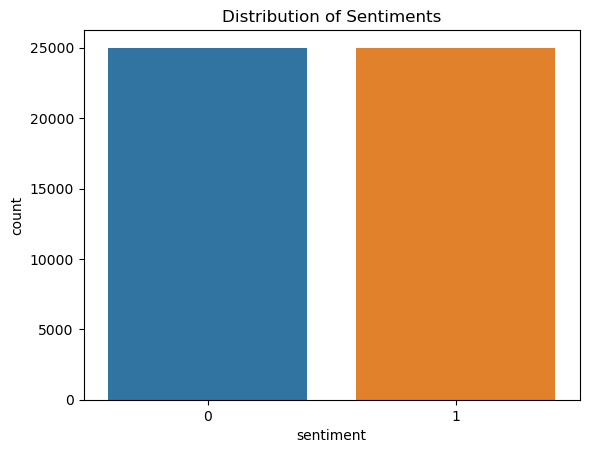

In [13]:
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.show()

## Review vs Review Lengths

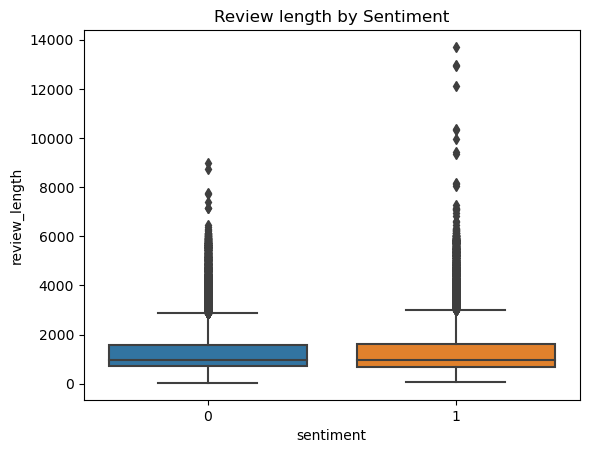

In [14]:
sns.boxplot(x='sentiment', y='review_length', data=df)
plt.title('Review length by Sentiment')
plt.show()

Here we can see that our earlier prediction does not hold as the review length medians are very close to each other. If anything, postive reviews tend to be very slightly higher.

## Word Counts vs Sentiments
Now let's check if extracting the negative and positive words for each review was worth our while by looking at the distribution of word counts of both types across both type of reviews.

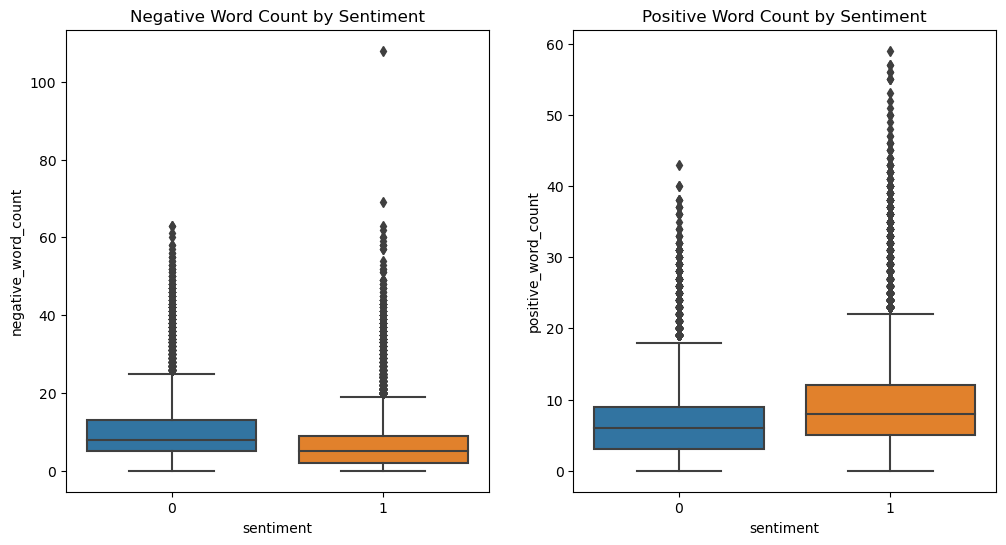

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='sentiment', y='negative_word_count', data=df)
plt.title('Negative Word Count by Sentiment')

plt.subplot(1, 2, 2)
sns.boxplot(x='sentiment', y='positive_word_count', data=df)
plt.title('Positive Word Count by Sentiment')
plt.show()

 As we can see from the above boxplots, negative reviews (sentiment 0) have higher counts of negative words, and positive reviews (sentiment 1) have higher counts of positive words. This pattern is expected and suggests that the extraction of negative and positive words from each review can be a valuable feature for sentiment analysis!

## VADER Score vs Sentiment
Now let's take a look at the distribution of VADER scores across both negative and positive reviews.

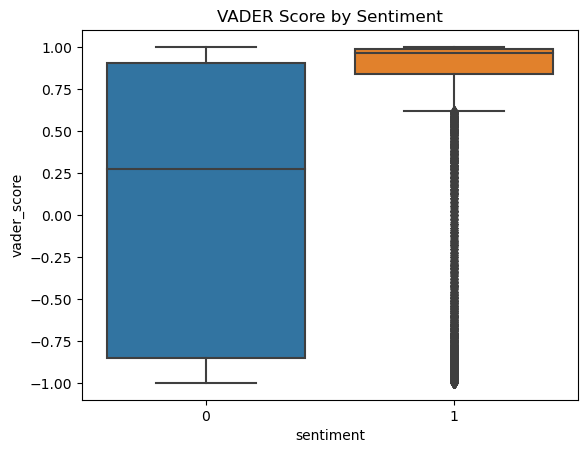

In [16]:
# Vader score by sentiment
sns.boxplot(x='sentiment', y='vader_score', data=df)
plt.title('VADER Score by Sentiment')
plt.show()

The VADER sentiment analysis is hitting the mark, assigning lower median scores to reviews with a negative sentiment (0) and higher ones to positive sentiment (1) reviews. It’s mostly accurate, although the spread of scores, particularly for positive sentiments, includes a few surprises dipping into negative territory, hinting at VADER's nuanced understanding of the reviews' emotional spectrum.

## Word Clouds
The below word clouds show us the most frequent positive words and the most frequent negative words

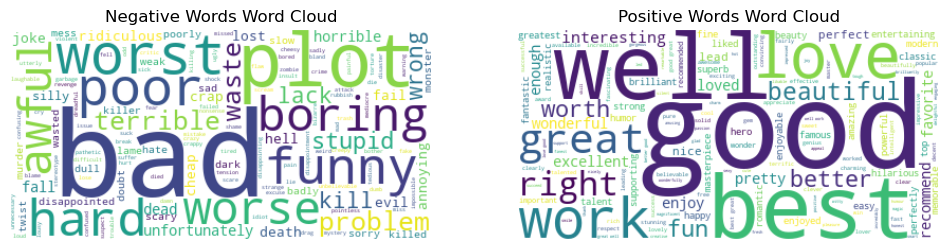

In [17]:
negative_reviews = df[df['sentiment'] == 0]
positive_reviews = df[df['sentiment'] == 1]

all_negative_words = ' '.join([' '.join(words) for words in negative_reviews['negative_words']])
all_positive_words = ' '.join([' '.join(words) for words in positive_reviews['positive_words']])

# Generate word clouds
wordcloud_neg = WordCloud(background_color='white').generate(all_negative_words)
wordcloud_pos = WordCloud(background_color='white').generate(all_positive_words)

plt.figure(figsize=(12, 6))

# Negative Words Wordcloud
plt.subplot(1, 2, 1) 
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words Word Cloud')

# Positive Words Wordcloud
plt.subplot(1, 2, 2) 
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Words Word Cloud')

plt.show()

# Modeling and Error Analysis


The first step in training our model is to separate our dataset into two groups: a training set, which contains 80% of the data, and a testing set, which contains 20% of the data. This allows us to assess how effectively our sentiment analysis models work with unseen data. We will use the pre-built `train_test_split` function from sci-kit learn to do this.

Each element of our 'tfidf_scores' column of our dataframe is a list of numerical values, which is a data format not supported by machine learning models of the sci-kit learn library. So, we first converted each list in this column to a numpy array. Then, we create a numpy array of these arrays. This is shown below. 


In [36]:
# Convert td-idf scores to an array of arrays.
df['tfidf_scores'] = df['tfidf_scores'].apply(np.array)
tfidf_array = np.vstack(df['tfidf_scores'].values)

# Selecting features that we use for our model (by dropping the unwanted ones) from the dataframe and combining them with this td-idf array.
x = df.drop(['review', 'clean_text','tfidf_scores', 'sentiment', 'negative_words', 'positive_words'], axis=1)
x = np.hstack((x, tfidf_array)) 

# Our outcome variable: the labels corresponding to the sentiment of each review.
y = df['sentiment']

# Allocate 20% of our dataset to the testing subset.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

For modeling we will use SVMs and Logistic Regression. Although different models, Support Vector Machine (SVM) with a linear kernel and Logistic Regression, are often used in similar contexts due to their effectiveness in binary classification problems.

## SVM
Using the SVC class from the scikit-learn package, we first initialize a Support Vector Machine (SVM) classifier. Using labeled training data, the SVM algorithm seeks to determine the ideal hyperplane for classifying unseen data. 

In [21]:
# Fit the model for our selected features using a linear kernel
svm_model = SVC(kernel='linear')  
svm_model.fit(x_train, y_train)

SVC(kernel='linear')

After training our model, we now evaluate its accuracy. To do this, we use the pre-built performance metrics from the sklearn library.

In [31]:
y_pred_svm = svm_model.predict(x_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm, average='macro')
recall = recall_score(y_test, y_pred_svm, average='macro')
f1 = f1_score(y_test, y_pred_svm, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred_svm)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.7327
Precision: 0.7331519979470709
Recall: 0.7325967030721715
F1 Score: 0.7325093085609802
Confusion Matrix:
 [[3797 1225]
 [1448 3530]]


In [32]:
svm_tfidf_report=classification_report(y_test,y_pred_svm,target_names=['negative','positive'])
print(svm_tfidf_report)

              precision    recall  f1-score   support

    negative       0.72      0.76      0.74      5022
    positive       0.74      0.71      0.73      4978

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



The accuracy score, as indicated by the results above, is 73.27%. With a precision score of 0.7332, approximately 73.32% of the reviews that were predicted to be positive are actually positive. A recall of 0.7326 indicates that around 73.26% of real positive reviews are captured by the model. The model exhibits a harmonious performance in terms of both accuracy and recall, indicated by the F1 Score of 0.7325.


## Logistic Regression


In [33]:
# Fit the logistic regression model
lr = LogisticRegression(penalty='l2', max_iter=1000, C=1, random_state=42) 
lr.fit(x_train, y_train)

LogisticRegression(C=1, max_iter=1000, random_state=42)

After training our logistic regression model, we now evaluate its accuracy. Again, we use the pre-built performance metrics from the sklearn library.

In [34]:
# Make predictions on the testing set
y_pred_lr = lr.predict(x_test)

# Evaluate performance metrics
accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
conf_matrix = confusion_matrix(y_test, y_pred_lr)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8506
Precision: 0.8359043578866178
Recall: 0.8708316593009241
F1 Score: 0.8530106257378984
Confusion Matrix:
 [[4171  851]
 [ 643 4335]]


In [35]:
lr_tfidf_report=classification_report(y_test,y_pred_lr,target_names=['negative','positive'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    negative       0.87      0.83      0.85      5022
    positive       0.84      0.87      0.85      4978

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



The accuracy score, as indicated by the results above, is 85.06%. With a precision score of 0.8359, approximately 83.59% of the reviews that were predicted to be positive are actually positive. A recall of 0.8708 indicates that around 87.08% of real positive reviews are captured by the model. The model exhibits a harmonious performance in terms of both accuracy and recall, indicated by the F1 Score of 0.853.


## Refining Our Model

In our continued pursuit of model refinement, we revisited the initial inclusion of the "Review Length" feature, a variable we initially considered crucial in discerning sentiments. Our preliminary rationale rested on the assumption that dissatisfied reviewers tend to express their sentiments in more extensive and detailed reviews.

However, a closer examination through exploratory data analysis (EDA) revealed a nuanced picture. Contrary to our initial hypothesis, the medians of review lengths across different sentiment categories were remarkably close. If anything, positive reviews exhibited only a marginal increase in length.

In [37]:
# We drop our review length column
x = df.drop(['review', 'clean_text','tfidf_scores', 'sentiment', 'negative_words', 'positive_words', 'review_length'], axis=1)
x = np.hstack((x, tfidf_array)) 

# Our outcome variable: the labels corresponding to the sentiment of each review.
y = df['sentiment']

# Allocate 20% of our dataset to the testing subset.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### SVM

In [38]:
# Fit the model for our new selected features using a linear kernel
svm_model = SVC(kernel='linear')  
svm_model.fit(x_train, y_train)

SVC(kernel='linear')

Again, we evaluate the performance of our new SVM model:

In [44]:
y_pred_svm = svm_model.predict(x_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm, average='macro')
recall = recall_score(y_test, y_pred_svm, average='macro')
f1 = f1_score(y_test, y_pred_svm, average='macro')
conf_matrix = confusion_matrix(y_test, y_pred_svm)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8634
Precision: 0.863631735859785
Recall: 0.8634563165142877
F1 Score: 0.8633889345036949
Confusion Matrix:
 [[4272  750]
 [ 616 4362]]


The accuracy score, as indicated by the results above, is 86.34%. With a precision score of 0.8636, approximately 86.36% of the reviews that were predicted to be positive are actually positive. A recall of 0.8634 indicates that around 86.34% of real positive reviews are captured by the model. The model exhibits a harmonious performance in terms of both accuracy and recall, indicated by the F1 Score of 0.8633. All of these performance scores are better than those of our initial SVM model.

### Logistic Regression

In [61]:
# Fit the logistic regression model for our new selected features
lr = LogisticRegression(penalty='l2', max_iter=1000, C=1, random_state=42) 
lr.fit(x_train, y_train)

LogisticRegression(C=1, max_iter=1000, random_state=42)

In [62]:
# Make predictions on the testing set
y_pred_lr = lr.predict(x_test)

# Evaluate performance metrics
accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
conf_matrix = confusion_matrix(y_test, y_pred_lr)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8611
Precision: 0.8486496988537012
Recall: 0.8774608276416231
F1 Score: 0.8628148148148148
Confusion Matrix:
 [[4243  779]
 [ 610 4368]]


In [63]:
lr_tfidf_report=classification_report(y_test,y_pred_lr,target_names=['negative','positive'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    negative       0.87      0.84      0.86      5022
    positive       0.85      0.88      0.86      4978

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



The accuracy score, as indicated by the results above, is 86.11%. With a precision score of 0.8486, approximately 84.86% of the reviews that were predicted to be positive are actually positive. A recall of 0.8775 indicates that around 86.34% of real positive reviews are captured by the model. The model exhibits a harmonious performance in terms of both accuracy and recall, indicated by the F1 Score of 0.8628. All of these performance scores are better than those of our initial logistic regression model.


#### When we look at the overall performance metrics of our new models that exclude "Review Length", there are notable improvements. Interestingly, all of the performance scores are higher compared to both to our initial logistic regression and SVM models, emphasizing the strategic choice we made to remove the "Review Length" feature.  Thus, leaving this feature out has made our sentiment analysis model more robust and accurate.



## Error Analysis
We will now conduct an error analysis on our improved model, where we omitted the "Review Length" feature  to help us identify how our model might need to be improved. We do this by looking at the characteristics of reviews that our model has incorrectly classified.

### SVM
**False Positive Rate**: 0.1470. This indicates that around 14.70% of the actual negative cases were incorrectly predicted as positive by the model.

**False Negative Rate**: 0.1179. This suggests that approximately 11.79% of the actual positive cases were incorrectly predicted as negative.

To conduct this error analysis, we will analyze a false positive review to understand why the model might have misclassified them.

In [60]:
y_test_array = y_test.values

false_positives_indices = np.where((y_pred_svm == 1) & (y_test_array == 0))[0]

if len(false_positives_indices) == 0:
    print("No false positives found.")
else:
    for idx in false_positives_indices[112:113]:
        print(f"Predicted: {y_pred_svm[idx]}, Actual: {y_test_array[idx]}")
        print("-" * 100)
        print("Review:")
        print(df['review'].values[idx])
        print("-" * 100)
        print(f"List of negative words: {df['negative_words'].values[idx]}")
        print(f"Count of negative words: {df['negative_word_count'].values[idx]}")
        print("-" * 100)
        print(f"List of positive words: {df['positive_words'].values[idx]}")
        print(f"Count of positive words: {df['positive_word_count'].values[idx]}")
        print("-" * 100)
        print(f"Count of question marks: {df['question_count'].values[idx]}")
        print(f"Count of exclamation marks: {df['exclamation_count'].values[idx]}")
        print("-" * 100)
        print(f"Vader score: {df['vader_score'].values[idx]}")
        print("-" * 100)

Predicted: 1, Actual: 0
----------------------------------------------------------------------------------------------------
Review:
This looks so good on paper - Matt Damon, Lawrence Fishbourne, Jean Reno, nice right? And a heist with $42 million - sounds like a kick-ass crime movie.<br /><br />Big disappointment - I reckon the stars got all the money because the production values on this are lousy.<br /><br />But more than that it the pseudo reservoir Dogs atmosphere when the easy crime goes wrong. It's very much made for TV stuff.<br /><br />All in all hugely disappointing - it score points for being what it is - but loses them massively for being, bluntly, not very interesting at all...
----------------------------------------------------------------------------------------------------
List of negative words: ['lousy', 'crime', 'disappointing', 'loses', 'disappointment', 'wrong']
Count of negative words: 6
----------------------------------------------------------------------------

Reading the above review, it clearly is a negative review. We could conclude this from phrases such as: "I reckon the stars got all the money because the production values on this are lousy." or "All in all hugely disappointing..". However, our model classified this review as a positive one. A reason for this false positive might be that the total count of positive words is equal to the count of negative words. Thus, if the model places a great importance on these features, the overall sentiment may be unclear to the model as these counts are equal. Also, the model could have misinterpreted seemingly positive phrases like "sounds like a kick-ass crime movie", which have a negative connotation when the whole sentence or text is taken into context. Furthermore, the model probably doesn't give much weight to the Vader score, as it is extremely low and is nearing -1, which suggests the review as a negative one.

### Logistic Regression
**False Positive Rate**: 0.1577. This means that about 15.77% of the actual negative cases were incorrectly predicted as positive by the model.

**False Negative Rate**: 0.1193. indicating that around 11.93% of the actual positive cases were incorrectly predicted as negative.

To conduct this error analysis, we will analyze a false positive review to understand why the model might have misclassified them.

In [118]:
false_positives_indices = np.where((y_pred_lr == 1) & (y_test_array == 0))[0]

if len(false_positives_indices) == 0:
    print("No false positives found.")
else:
    for idx in false_positives_indices[3:4]:
        print(f"Predicted: {y_pred_svm[idx]}, Actual: {y_test_array[idx]}")
        print("-" * 100)
        print("Review:")
        print(df['review'].values[idx])
        print("-" * 100)
        print(f"List of negative words: {df['negative_words'].values[idx]}")
        print(f"Count of negative words: {df['negative_word_count'].values[idx]}")
        print("-" * 100)
        print(f"List of positive words: {df['positive_words'].values[idx]}")
        print(f"Count of positive words: {df['positive_word_count'].values[idx]}")
        print("-" * 100)
        print(f"Count of question marks: {df['question_count'].values[idx]}")
        print(f"Count of exclamation marks: {df['exclamation_count'].values[idx]}")
        print("-" * 100)
        print(f"Vader score: {df['vader_score'].values[idx]}")
        print("-" * 100)

Predicted: 1, Actual: 0
----------------------------------------------------------------------------------------------------
Review:
Unbelievable. I never saw something like that. Everything is bad; really bad. From photography (lots of scenes without focus!) to the acting (the young female is terrible). And what can we say about those helicopters made in Paint Brush...? Really amazing B, I mean, Z film.<br /><br />The plot are bad, cliché and bad wrote. Basics conveniences to the screenplay seems to work. I can't even think a young student of cinema making this movie. Nothing justify it.<br /><br />I recommend that you don't even think to see this movie. Sleep or play solitary are best choices. ;)<br /><br />xxx
----------------------------------------------------------------------------------------------------
List of negative words: ['bad', 'unbelievable', 'plot', 'terrible']
Count of negative words: 4
---------------------------------------------------------------------------------

Reading the above review, it clearly is a negative review. We could deduct this from "Everything is bad; really bad." or "I recommend that you don't even think to see this movie.". However, our model labelled this as a positive review. A reason for this false positive might be that the list of positive words outnumber the negative words. Thus, the overall sentiment that is conveyed by the contextual use of these words may be overlooked if the model places a great deal of emphasis on word counts. Also, the model might have found it difficult to detect sarcastic tone and end up misinterpreting the user's tone. Furthermore, the model probably doesn't give much weight to the Vader score, as it is extremely low, nearing -1 which should've flagged it as a negative review.

# Conclusion

By effectively utilizing supervised machine learning algorithms and NLP techniques we have achieved our project's objectives. We were able to make a robust predictive model by going through stages like feature extraction, data visualization, and feature selection. Thus our objectives and motivations are met as our model provides a strong basis for understanding the sentiments underlying user-generated IMDb movie reviews. By doing error analysis, we are able to further identify several areas in which our model is lacking, allowing us to precisely target areas for improvement. For example, conducting a feature significance analysis, employing ensemble techniques, and utilizing more sophisticated NLP algorithms to accurately capture the complex emotions underlying these assessments would further improve the accuracy of our model and understand the nuanced sentiments behind IMDb reviews.

# References
* Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews."
Proceedings of the ACM SIGKDD International Conference on Knowledge
Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle,
Washington, USA,
* Bing Liu, Minqing Hu and Junsheng Cheng. "Opinion Observer: Analyzing
and Comparing Opinions on the Web." Proceedings of the 14th
International World Wide Web conference (WWW-2005), May 10-14, 2005, Chiba, Japan.